In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import gc
pd.options.display.max_rows = 20
import seaborn as sns
import matplotlib.pyplot as plt

## Objectives
This study is to predict credit default of American Express [amex-kaggle-competition](https://www.kaggle.com/competitions/amex-default-prediction). Since the data is large for kaggle notebook, we will downsample the data to fit in the memory (16GB) by reading the first 20000 data points only. First we load the raw data and perform exploratory data analysis (EDA) to understand the features and the outcome variables.

## Loading and Exploratory Data Analysis

In [3]:
train_data = pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv', nrows=20000)
train_labels = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
data = pd.merge(train_data, train_labels, how='inner', left_on=['customer_ID'], right_on=['customer_ID'])

In [4]:
# clean up memory
del train_labels
del train_data
gc.collect()

21

### Features summary
Let's take a look at the summary of the features. The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,19851.0,0.659791,0.243801,-2.569212e-01,0.480397,0.699095,0.868872,1.009926
D_39,20000.0,0.152223,0.268263,8.701630e-07,0.004582,0.009219,0.214144,5.009303
B_1,20000.0,0.128426,0.218512,-1.414690e-01,0.008930,0.033051,0.131177,1.323981
B_2,19998.0,0.609829,0.404588,8.675709e-06,0.088689,0.813778,1.002129,1.010000
R_1,20000.0,0.076314,0.218224,3.154721e-07,0.002874,0.005768,0.008637,2.502416
...,...,...,...,...,...,...,...,...
D_142,3203.0,0.365908,0.244865,-8.804185e-03,0.153710,0.353421,0.546272,1.486382
D_143,19654.0,0.167112,0.368618,2.360950e-07,0.002967,0.005949,0.008926,1.010000
D_144,19851.0,0.048560,0.178911,5.802874e-07,0.002684,0.005383,0.008146,1.343284
D_145,19654.0,0.055100,0.201799,1.577788e-07,0.002994,0.005987,0.008958,4.282032


Feature scale is quite good, not much features have max > 100

In [6]:
data.head().T

,0,1,2,3,4
customer_ID,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
S_2,2017-03-09,2017-04-07,2017-05-28,2017-06-13,2017-07-16
P_2,0.938469,0.936665,0.95418,0.960384,0.947248
D_39,0.001733,0.005775,0.091505,0.002455,0.002483
B_1,0.008724,0.004923,0.021655,0.013683,0.015193
...,...,...,...,...,...
D_142,NaN,NaN,NaN,NaN,NaN
D_143,0.000569,0.009576,0.003429,0.008419,0.00167
D_144,0.00061,0.005492,0.006986,0.006527,0.008126
D_145,0.002674,0.009217,0.002603,0.0096,0.009827


Distribution of the target variables

<AxesSubplot:>

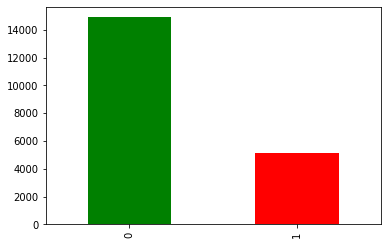

In [7]:
data.target.value_counts().plot.bar(color=['green', 'red'])

The data is slightly skewed

Drop `S_2` date columns and columns with NA > 75%

In [8]:
data.drop(['S_2'], axis=1, inplace=True)

In [9]:
mask = data.isnull().mean() > 0.75
data.drop(data.columns[mask], axis=1, inplace=True)

In [10]:
data.shape

(20000, 167)

Mask the int & float columns

In [11]:
mask_int = data.dtypes == int
int_cols = data.columns[mask_int]
print(int_cols)

Index(['B_31', 'target'], dtype='object')


In [12]:
mask_float = data.dtypes == float
float_cols = data.columns[mask_float]
print(float_cols)

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'D_130', 'D_131', 'D_133', 'R_28', 'D_139', 'D_140', 'D_141', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=162)


### Features vs Target Pair Plot
Since there is a lot of columns, we will chose first highest 10 columns for plotting only

In [13]:
correlations  = data[float_cols].corrwith(data.target)
correlations = correlations.abs()
correlations.sort_values(inplace=True, ascending=False)
correlations[:10]

P_2     0.622775
D_48    0.575249
D_61    0.522553
D_44    0.488481
B_9     0.487222
D_55    0.479244
B_18    0.477223
D_75    0.471424
B_2     0.465090
D_58    0.460988
dtype: float64

In [14]:
high_corr_cols = correlations[:10].index
high_corr_cols  = list(high_corr_cols)
high_corr_cols.append('target')

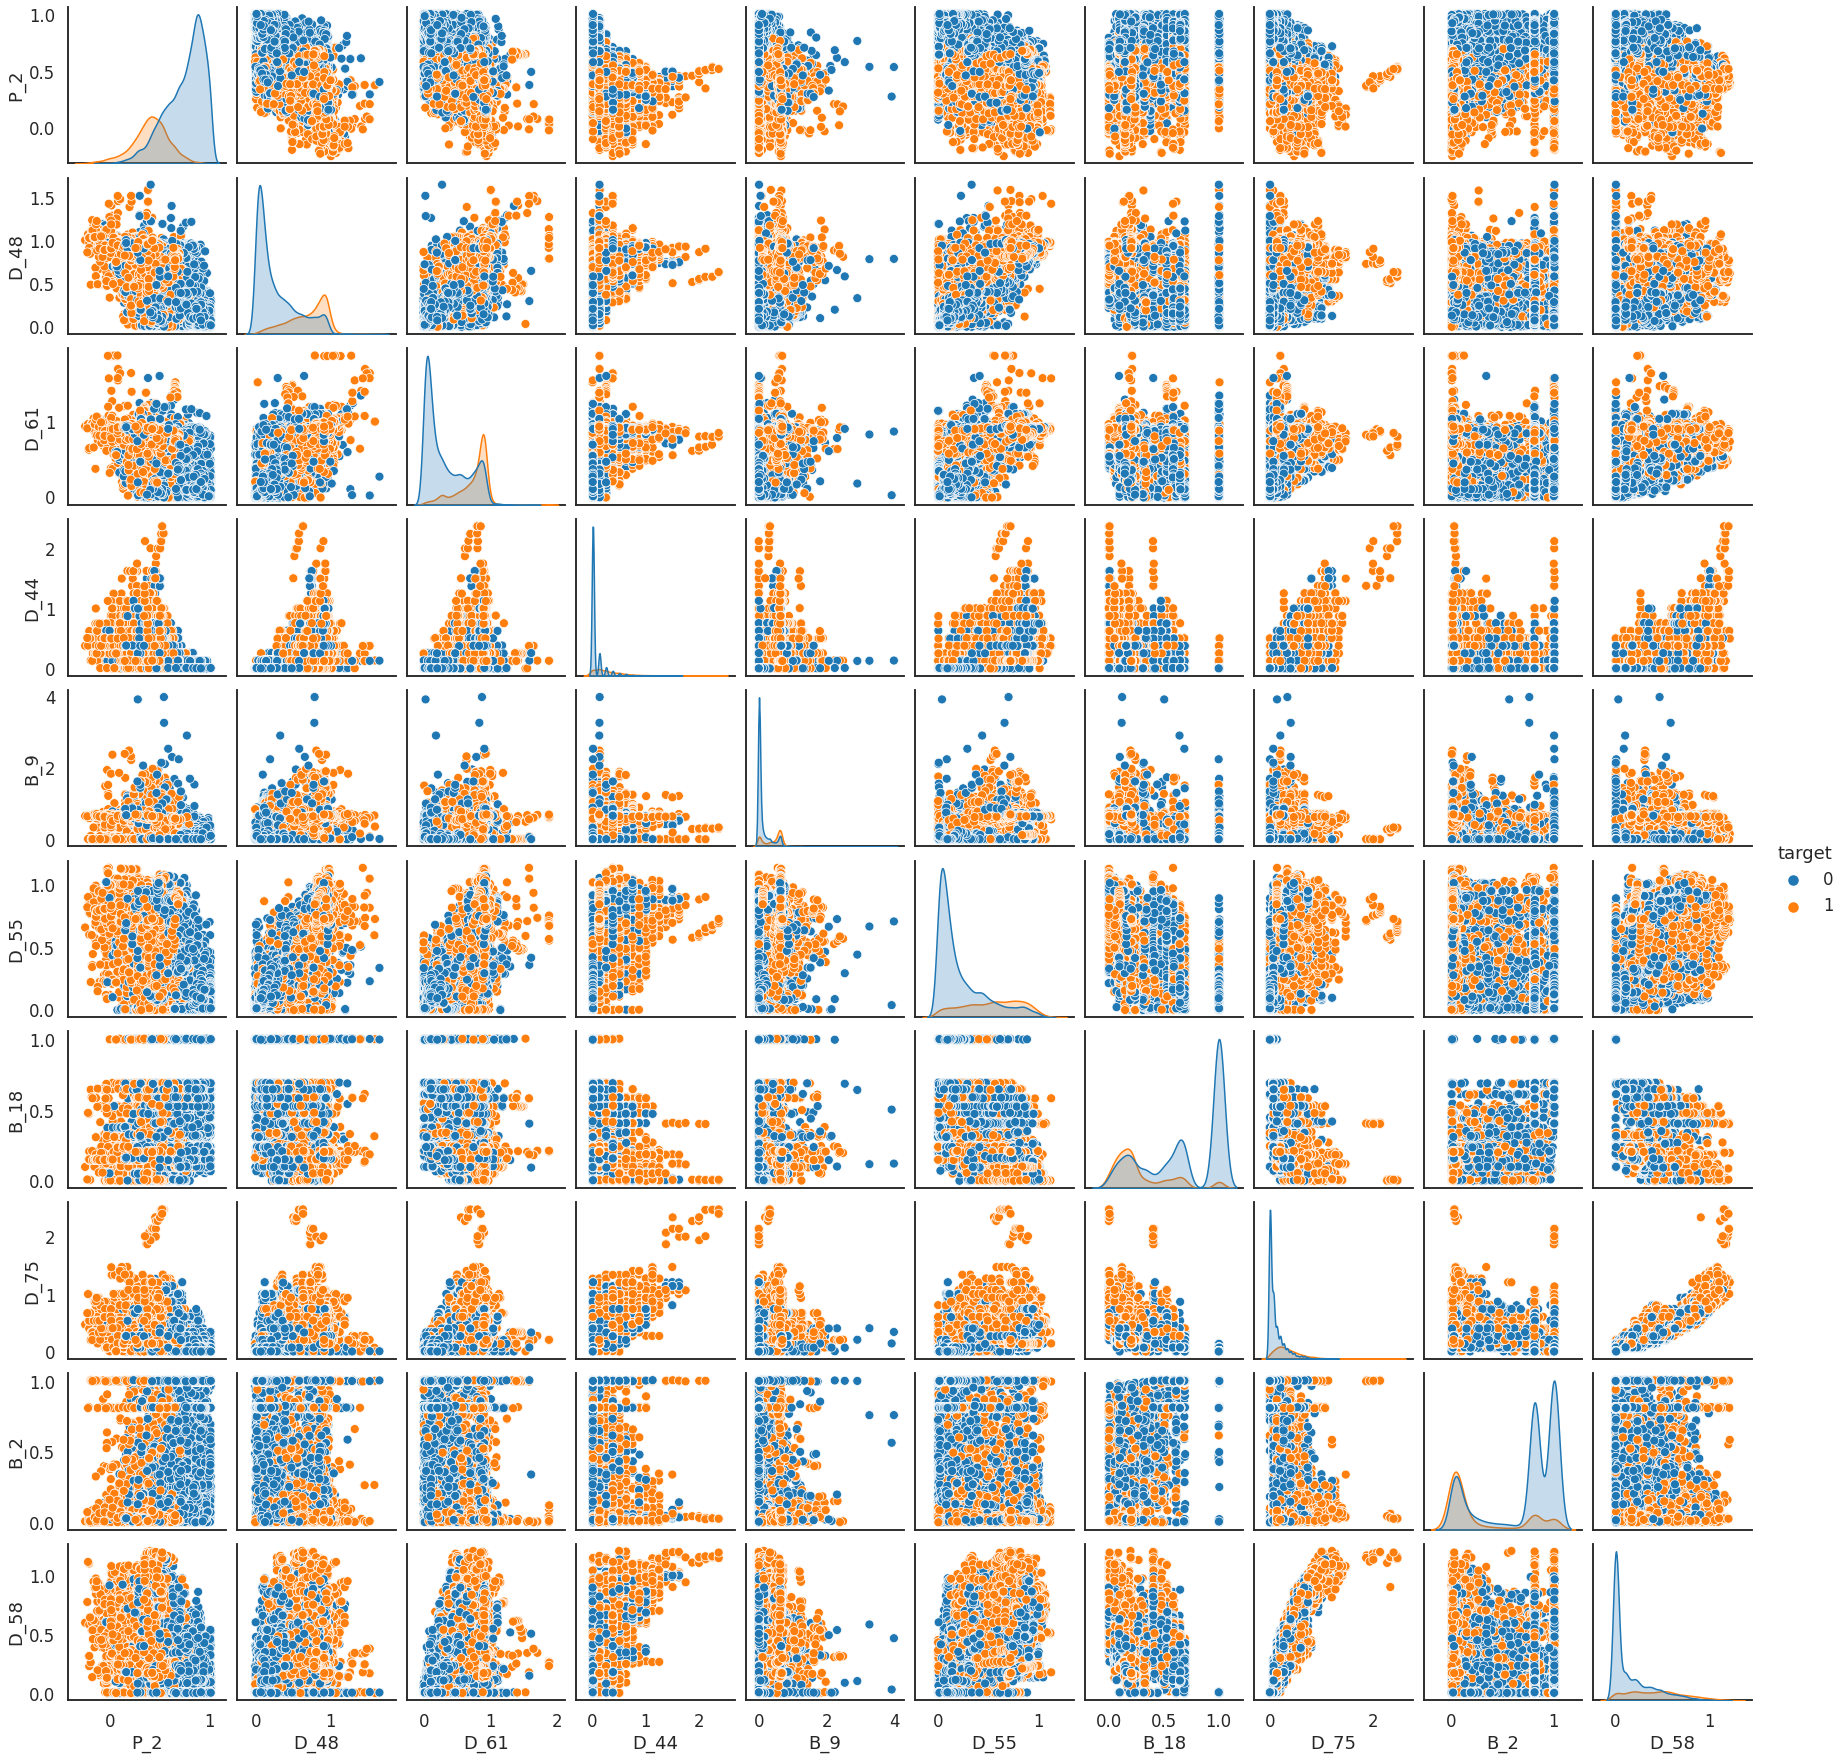

In [15]:
sns.set_context('talk')
sns.set_style('white')
sns.pairplot(data[high_corr_cols], hue='target')

With this data, we will perform one hot encoding for the categorical data and then perform various classification algorithm to build the model to predict the default rate of the amex credit card user

## One Hot Encoding

Categorical columns for one hot encoding 

In [16]:
mask = data.dtypes == object
mask['customer_ID'] = False
categorical_cols = data.columns[mask]
print(categorical_cols)

Index(['D_63', 'D_64'], dtype='object')


In [17]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

small_num_ohc_cols.sum()

8

In [18]:
data['D_63'].value_counts()

CO    14848
CR     3209
CL     1766
XZ      108
XM       36
XL       33
Name: D_63, dtype: int64

In [19]:
data['D_64'].value_counts()

O     11126
U      5280
R      2746
-1      122
Name: D_64, dtype: int64

In [20]:
num_ohc_cols

D_63    6
D_64    4
dtype: int64

In [21]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [22]:
%%time
# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()
for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data[col]).astype(int)
    
    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_cat_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data.index, 
                          columns=col_names)
    
    # Append the new data to the dataframe
    data = pd.concat([data, new_df], axis=1)
    
    # Remove the original column from the dataframe
    data = data.drop(col, axis=1)

CPU times: user 75.4 ms, sys: 25 ms, total: 100 ms
Wall time: 100 ms


In [23]:
data.head().T

,0,1,2,3,4
customer_ID,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
P_2,0.938469,0.936665,0.95418,0.960384,0.947248
D_39,0.001733,0.005775,0.091505,0.002455,0.002483
B_1,0.008724,0.004923,0.021655,0.013683,0.015193
B_2,1.006838,1.000653,1.009672,1.0027,1.000727
...,...,...,...,...,...
D_64_cat_0,0.0,0.0,0.0,0.0,0.0
D_64_cat_1,1.0,1.0,1.0,1.0,1.0
D_64_cat_2,0.0,0.0,0.0,0.0,0.0
D_64_cat_3,0.0,0.0,0.0,0.0,0.0


## NAN Value

For non categorical data, there is nan value in the data, hence we need to fill it or drop the entire observation before we feed into our linear model. Let's fill with mean value

In [24]:
for col in data.columns:
    if col in int_cols or col in float_cols:
        mean_value = data[col].mean()
        print('Filling NAN of {} with mean value of {}'.format(col, mean_value))
        data[col].fillna(value=mean_value, inplace=True)

Filling NAN of P_2 with mean value of 0.6597912750755061
Filling NAN of D_39 with mean value of 0.15222257832929187
Filling NAN of B_1 with mean value of 0.12842649663514347
Filling NAN of B_2 with mean value of 0.6098291372160711
Filling NAN of R_1 with mean value of 0.07631383677584944
Filling NAN of S_3 with mean value of 0.2264236516958893
Filling NAN of D_41 with mean value of 0.06144383127199815
Filling NAN of B_3 with mean value of 0.139009188099959
Filling NAN of D_43 with mean value of 0.15574036787179987
Filling NAN of D_44 with mean value of 0.12374205776967206
Filling NAN of B_4 with mean value of 0.17963366056495092
Filling NAN of D_45 with mean value of 0.2587793705382291
Filling NAN of B_5 with mean value of 0.08598194918091695
Filling NAN of R_2 with mean value of 0.04433265013860604
Filling NAN of D_46 with mean value of 0.4746816890464209
Filling NAN of D_47 with mean value of 0.4189520043795902
Filling NAN of D_48 with mean value of 0.3859295482807024
Filling NAN of 

## Train Validation Test Split

Let's split the data into train, validation and test set. We will train and crossvalidation the data on train,validation set and test our price prediction on test set. The measure of error will be mean square error

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
y_col = 'target'
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
X_data = X_data.drop(['customer_ID'], axis=1)
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)

<AxesSubplot:>

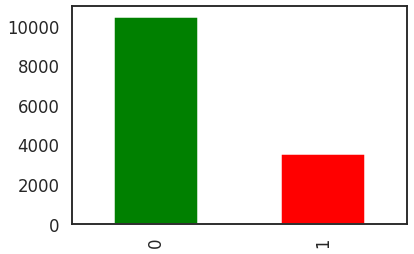

In [27]:
y_train.value_counts().plot.bar(color=['green', 'red'])

## Baseline: Simple Linear Regression

No feature scaling as the max(features) ~300, we can try scaling later

In [28]:
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
# L2 penalty to shrink coefficients without removing any features from the model
penalty= 'l2'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use lbfgs for L2 penalty and multinomial classes
solver = 'lbfgs'
# Max iteration = 1000
max_iter = 1000
# Define a logistic regression model with above arguments
l2_model = LogisticRegression(random_state=42, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter)

In [31]:
l2_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [32]:
l2_preds = l2_model.predict(X_test)

In [33]:
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=10, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

In [34]:
results = []
result = evaluate(y_test, l2_preds, "Baseline Logistic Regression")
results.append(result)

In [35]:
results

[{'type': 'Baseline Logistic Regression',
  'accuracy': 0.8855,
  'recall': 0.7554140127388536,
  'auc': 0.8435083607712326,
  'precision': 0.796507723304231,
  'fscore': 0.755800087072289}]

Ploting confusion matrix

In [36]:
cf = confusion_matrix(y_test, l2_preds)

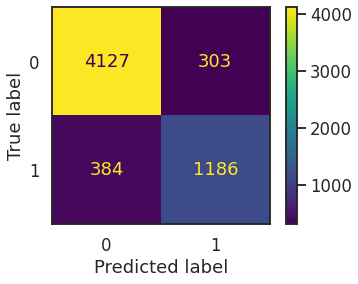

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=l2_model.classes_)
disp.plot()

## Baseline: Random Forest

No hyperparameter tunning

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rs = 42
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [40]:
%%time
preds, model = build_rf(X_train, y_train, X_test)
result = evaluate(y_test, preds, "Baseline Random Forest")
print(result)
results.append(result)

{'type': 'Baseline Random Forest', 'accuracy': 0.946, 'recall': 0.8828025477707007, 'auc': 0.9255999194835445, 'precision': 0.908256880733945, 'fscore': 0.8830475757919839}
CPU times: user 19.6 s, sys: 22.4 ms, total: 19.7 s
Wall time: 19.7 s


In [41]:
results

[{'type': 'Baseline Logistic Regression',
  'accuracy': 0.8855,
  'recall': 0.7554140127388536,
  'auc': 0.8435083607712326,
  'precision': 0.796507723304231,
  'fscore': 0.755800087072289},
 {'type': 'Baseline Random Forest',
  'accuracy': 0.946,
  'recall': 0.8828025477707007,
  'auc': 0.9255999194835445,
  'precision': 0.908256880733945,
  'fscore': 0.8830475757919839}]

## Rescale Data with StandardScaler

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
standard_scaler = StandardScaler()
X_data = pd.DataFrame(standard_scaler.fit_transform(X_data), columns=X_data.columns)

In [44]:
X_data.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,20000.0,1.570299e-16,1.000025,-3.774268,-0.734494,0.149880,0.857052,1.441567
D_39,20000.0,1.421085e-18,1.000025,-0.567449,-0.550373,-0.533085,0.230830,18.106125
B_1,20000.0,-4.334311e-17,1.000025,-1.235181,-0.546878,-0.436488,0.012586,5.471474
B_2,20000.0,1.652012e-16,1.000025,-1.507376,-1.288043,0.504124,0.969695,0.989156
R_1,20000.0,-1.563194e-17,1.000025,-0.349712,-0.336543,-0.323280,-0.310132,11.117780
...,...,...,...,...,...,...,...,...
D_64_cat_0,20000.0,-2.060574e-17,1.000025,-0.078342,-0.078342,-0.078342,-0.078342,12.764577
D_64_cat_1,20000.0,-5.684342e-17,1.000025,-1.119721,-1.119721,0.893080,0.893080,0.893080
D_64_cat_2,20000.0,-4.902745e-17,1.000025,-0.398938,-0.398938,-0.398938,-0.398938,2.506655
D_64_cat_3,20000.0,-5.506706e-17,1.000025,-0.598912,-0.598912,-0.598912,1.669694,1.669694


All the columns now have `mean` = 0 and `standard deviation` = 1

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)

## Random Forest with Scaled Data

In [46]:
%%time
preds, model = build_rf(X_train, y_train, X_test)
result = evaluate(y_test, preds, "Random Forest with Scaled Data")
print(result)
results.append(result)

{'type': 'Random Forest with Scaled Data', 'accuracy': 0.9445, 'recall': 0.8796178343949045, 'auc': 0.9235560955270233, 'precision': 0.9055737704918033, 'fscore': 0.8798675287809493}
CPU times: user 19.6 s, sys: 4.48 ms, total: 19.6 s
Wall time: 19.6 s


In [47]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [48]:
results

[{'type': 'Baseline Logistic Regression',
  'accuracy': 0.8855,
  'recall': 0.7554140127388536,
  'auc': 0.8435083607712326,
  'precision': 0.796507723304231,
  'fscore': 0.755800087072289},
 {'type': 'Baseline Random Forest',
  'accuracy': 0.946,
  'recall': 0.8828025477707007,
  'auc': 0.9255999194835445,
  'precision': 0.908256880733945,
  'fscore': 0.8830475757919839},
 {'type': 'Random Forest with Scaled Data',
  'accuracy': 0.9445,
  'recall': 0.8796178343949045,
  'auc': 0.9235560955270233,
  'precision': 0.9055737704918033,
  'fscore': 0.8798675287809493}]

No improvement

## Random Forest Grid Search

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
rs=42
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params, grid_search

In [51]:
%%time
best_params_results, grid_search_results = grid_search_rf(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 35min 58s, sys: 1.21 s, total: 35min 59s
Wall time: 36min 1s


In [52]:
print(best_params_results)

{'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [53]:
preds = grid_search_results.predict(X_test)
result = evaluate(y_test, preds, "Random Forest with Scaled Data")
print(result)
results.append(result)

{'type': 'Random Forest with Scaled Data', 'accuracy': 0.9408333333333333, 'recall': 0.870063694267516, 'auc': 0.9179889577432387, 'precision': 0.9004614370468029, 'fscore': 0.8703545991912539}


In [54]:
results

[{'type': 'Baseline Logistic Regression',
  'accuracy': 0.8855,
  'recall': 0.7554140127388536,
  'auc': 0.8435083607712326,
  'precision': 0.796507723304231,
  'fscore': 0.755800087072289},
 {'type': 'Baseline Random Forest',
  'accuracy': 0.946,
  'recall': 0.8828025477707007,
  'auc': 0.9255999194835445,
  'precision': 0.908256880733945,
  'fscore': 0.8830475757919839},
 {'type': 'Random Forest with Scaled Data',
  'accuracy': 0.9445,
  'recall': 0.8796178343949045,
  'auc': 0.9235560955270233,
  'precision': 0.9055737704918033,
  'fscore': 0.8798675287809493},
 {'type': 'Random Forest with Scaled Data',
  'accuracy': 0.9408333333333333,
  'recall': 0.870063694267516,
  'auc': 0.9179889577432387,
  'precision': 0.9004614370468029,
  'fscore': 0.8703545991912539}]

In [55]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Baseline: Linear Regression", "Baseline: Random Forest", "Random Forest with Scaled Data", "Random Forest Grid Search"])
    plt.show()

In [56]:
from matplotlib.pyplot import figure

                             type  accuracy    recall       auc  precision  \
0    Baseline Logistic Regression  0.885500  0.755414  0.843508   0.796508   
1          Baseline Random Forest  0.946000  0.882803  0.925600   0.908257   
2  Random Forest with Scaled Data  0.944500  0.879618  0.923556   0.905574   
3  Random Forest with Scaled Data  0.940833  0.870064  0.917989   0.900461   

     fscore  
0  0.755800  
1  0.883048  
2  0.879868  
3  0.870355  


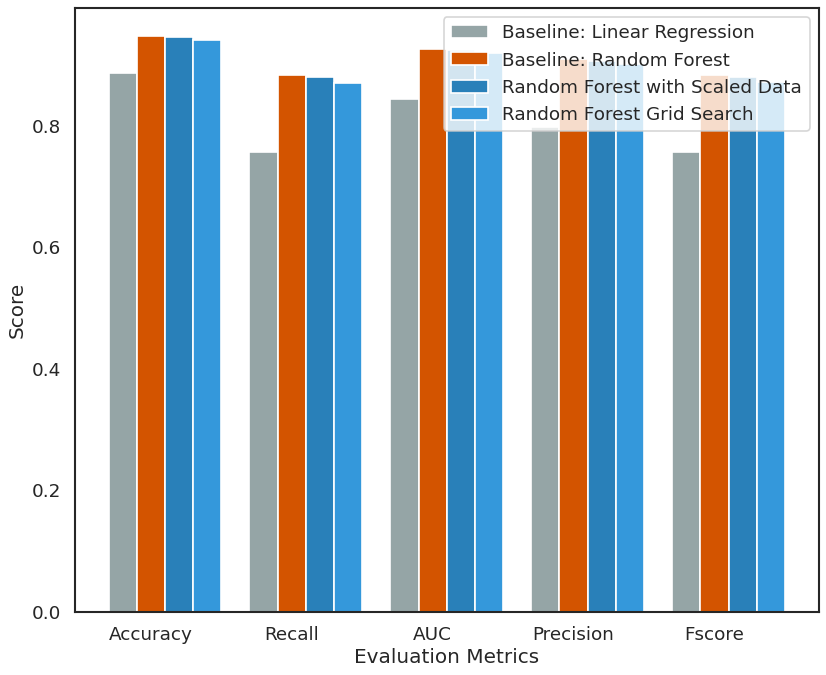

In [57]:
visualize_eval_metrics(results)

Baseline: Random Forest is actually very good model. Let's try xgboost model and lightgbm

## Baseline XGBoost

In [58]:
import xgboost as xgb

In [59]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [60]:
results.pop(-1)

{'type': 'Random Forest with Scaled Data',
 'accuracy': 0.9408333333333333,
 'recall': 0.870063694267516,
 'auc': 0.9179889577432387,
 'precision': 0.9004614370468029,
 'fscore': 0.8703545991912539}

In [61]:
results.pop(-2)

{'type': 'Baseline Random Forest',
 'accuracy': 0.946,
 'recall': 0.8828025477707007,
 'auc': 0.9255999194835445,
 'precision': 0.908256880733945,
 'fscore': 0.8830475757919839}

In [62]:
preds = xgb_model.predict(X_test)
result = evaluate(y_test, preds, "XGB with Scaled Data")
print(result)
results.append(result)

{'type': 'XGB with Scaled Data', 'accuracy': 0.9701666666666666, 'recall': 0.9292993630573249, 'auc': 0.956974737962071, 'precision': 0.9554682383759004, 'fscore': 0.9295514328789418}


In [63]:
results

[{'type': 'Baseline Logistic Regression',
  'accuracy': 0.8855,
  'recall': 0.7554140127388536,
  'auc': 0.8435083607712326,
  'precision': 0.796507723304231,
  'fscore': 0.755800087072289},
 {'type': 'Random Forest with Scaled Data',
  'accuracy': 0.9445,
  'recall': 0.8796178343949045,
  'auc': 0.9235560955270233,
  'precision': 0.9055737704918033,
  'fscore': 0.8798675287809493},
 {'type': 'XGB with Scaled Data',
  'accuracy': 0.9701666666666666,
  'recall': 0.9292993630573249,
  'auc': 0.956974737962071,
  'precision': 0.9554682383759004,
  'fscore': 0.9295514328789418}]

In [64]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Baseline: Linear Regression", "Baseline: Random Forest", "XGB with Scaled Data", "LighGBM with Scaled Data"])
    plt.show()

## Baseline LightGBM

In [65]:
import lightgbm

In [66]:
lgbm_model = lightgbm.LGBMClassifier()
lgbm_model.fit(X_train, y_train)
preds = lgbm_model.predict(X_test)
result = evaluate(y_test, preds, "LightGBM with Scaled Data")
print(result)
results.append(result)

{'type': 'LightGBM with Scaled Data', 'accuracy': 0.9591666666666666, 'recall': 0.913375796178344, 'auc': 0.9443854150191946, 'precision': 0.9293583927414129, 'fscore': 0.9135313448086638}


                             type  accuracy    recall       auc  precision  \
0    Baseline Logistic Regression  0.885500  0.755414  0.843508   0.796508   
1  Random Forest with Scaled Data  0.944500  0.879618  0.923556   0.905574   
2            XGB with Scaled Data  0.970167  0.929299  0.956975   0.955468   
3       LightGBM with Scaled Data  0.959167  0.913376  0.944385   0.929358   

     fscore  
0  0.755800  
1  0.879868  
2  0.929551  
3  0.913531  


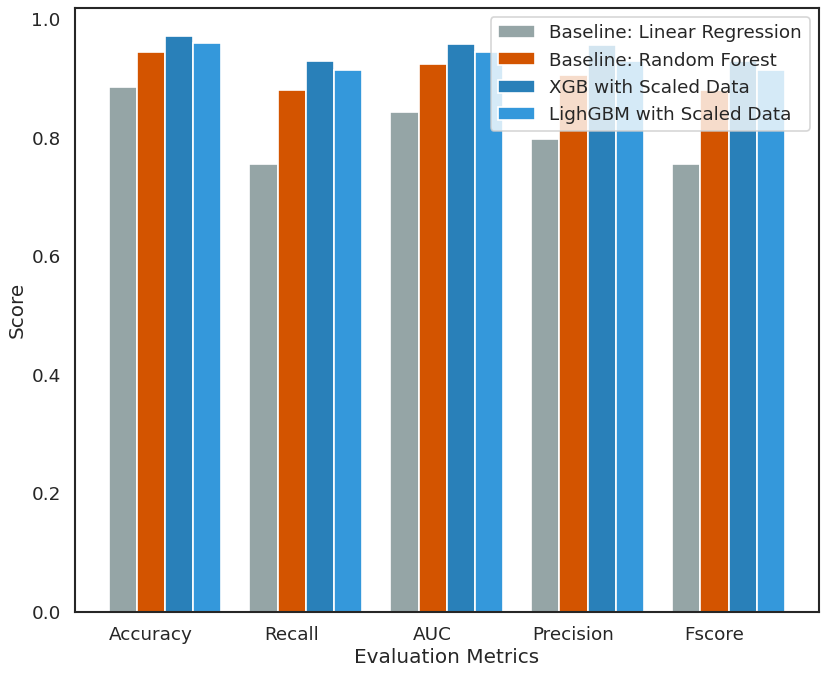

In [67]:
visualize_eval_metrics(results)

XGBoost is the best model sofar

## Resampling with SMOTHE

In [68]:
!pip install imbalanced-learn==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.0
    Uninstalling imbalanced-learn-0.9.0:
      Successfully uninstalled imbalanced-learn-0.9.0


In [69]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [70]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = 42)

In [71]:
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

<AxesSubplot:>

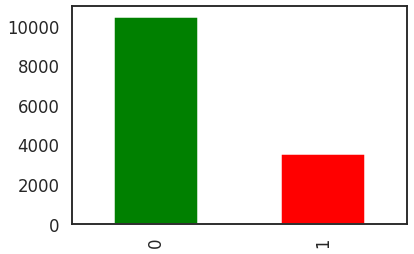

In [72]:
y_train.value_counts().plot.bar(color=['green', 'red'])

<AxesSubplot:>

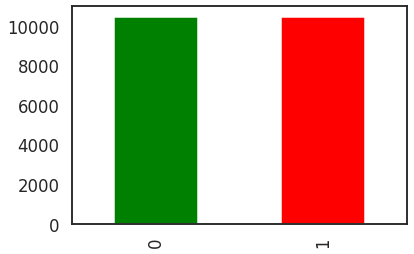

In [73]:
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [74]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_smo, y_smo)
preds = xgb_model.predict(X_test)
result = evaluate(y_test, preds, "XGB with SMOTHE resampling Data")
results.pop(0)  ## remove the logistic regression results
print(result)
results.append(result)
results

{'type': 'XGB with SMOTHE resampling Data', 'accuracy': 0.965, 'recall': 0.935031847133758, 'auc': 0.9553263073140573, 'precision': 0.9314720812182741, 'fscore': 0.9349964685702755}


[{'type': 'Random Forest with Scaled Data',
  'accuracy': 0.9445,
  'recall': 0.8796178343949045,
  'auc': 0.9235560955270233,
  'precision': 0.9055737704918033,
  'fscore': 0.8798675287809493},
 {'type': 'XGB with Scaled Data',
  'accuracy': 0.9701666666666666,
  'recall': 0.9292993630573249,
  'auc': 0.956974737962071,
  'precision': 0.9554682383759004,
  'fscore': 0.9295514328789418},
 {'type': 'LightGBM with Scaled Data',
  'accuracy': 0.9591666666666666,
  'recall': 0.913375796178344,
  'auc': 0.9443854150191946,
  'precision': 0.9293583927414129,
  'fscore': 0.9135313448086638},
 {'type': 'XGB with SMOTHE resampling Data',
  'accuracy': 0.965,
  'recall': 0.935031847133758,
  'auc': 0.9553263073140573,
  'precision': 0.9314720812182741,
  'fscore': 0.9349964685702755}]

In [75]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Baseline: Random Forest", "XGB with Scaled Data", "LighGBM with Scaled Data", "XGB with SMOTHE resampling Data"])
    plt.show()

                              type  accuracy    recall       auc  precision  \
0   Random Forest with Scaled Data  0.944500  0.879618  0.923556   0.905574   
1             XGB with Scaled Data  0.970167  0.929299  0.956975   0.955468   
2        LightGBM with Scaled Data  0.959167  0.913376  0.944385   0.929358   
3  XGB with SMOTHE resampling Data  0.965000  0.935032  0.955326   0.931472   

     fscore  
0  0.879868  
1  0.929551  
2  0.913531  
3  0.934996  


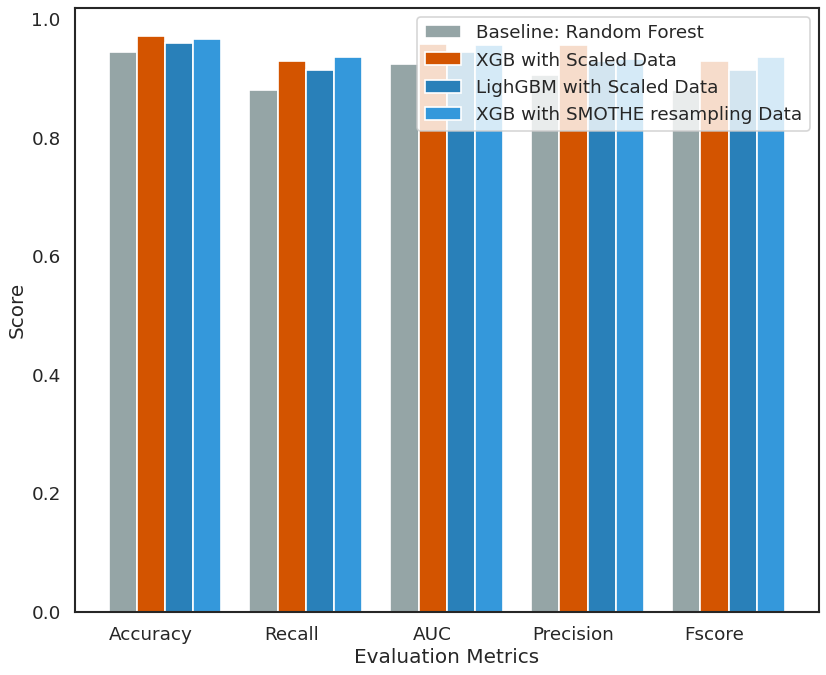

In [76]:
visualize_eval_metrics(results)

Slightly improved recall but lower precision with SMOTHE resampling data. Overall high f10-score. Let's choose the XGB model with SMOTHE resampling data

## Model interpretation

In [77]:
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, plot_partial_dependence

### Built in features importances

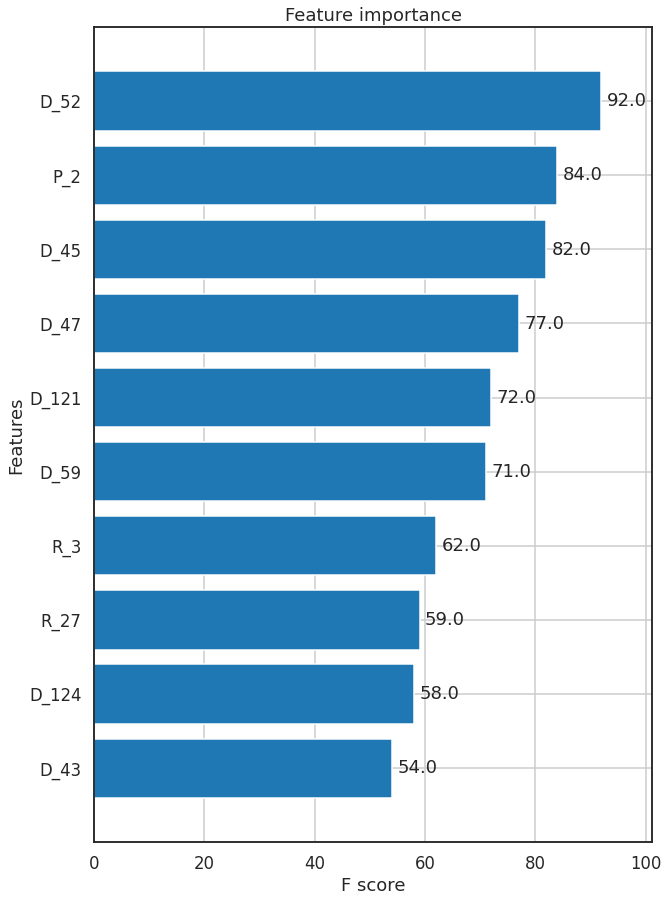

In [78]:
fig, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.8, ax=ax)
plt.show()

### Partial Dependency Plot (PDP)

In [79]:
from sklearn.inspection import permutation_importance, plot_partial_dependence

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


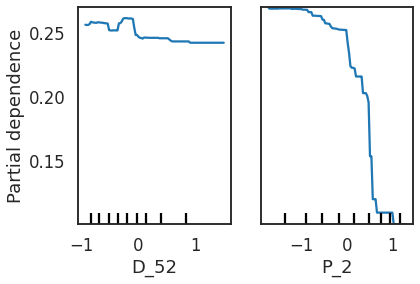

In [80]:
important_features = ['D_52', 'P_2']
plot_partial_dependence(estimator=xgb_model, 
                        X=X_train, 
                        features=important_features,
                        random_state=42)

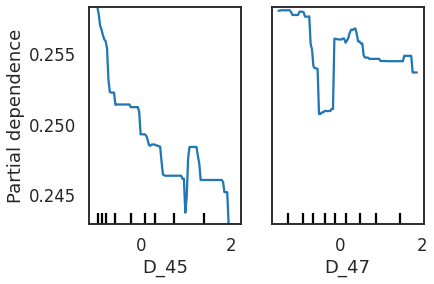

In [81]:
important_features = ['D_45', 'D_47']
plot_partial_dependence(estimator=xgb_model, 
                        X=X_train, 
                        features=important_features,
                        random_state=42)

## Logistic regression surrogate model

In [82]:
lm_surrogate = LogisticRegression(max_iter=1000, 
                                  random_state=123, penalty='l1', solver='liblinear')
lm_surrogate.fit(X_test, preds)

LogisticRegression(max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')

In [83]:
y_surrogate = lm_surrogate.predict(X_test)

In [84]:
metrics.accuracy_score(preds, y_surrogate)

0.914

The score is around 0.914 which means the logistic regression surrogate model was able to reproduce about 91.4% of the original black-box model correctly.

In [85]:
# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(100,50))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    
    plt.show()

In [86]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [87]:
coef_dict = get_feature_coefs(lm_surrogate)
coef_dict

{'P_2': -1.1080906057244315,
 'D_74': -0.5869730501303577,
 'B_5': -0.5556952567430801,
 'D_129': -0.5292285259814566,
 'B_13': -0.5199901614900917,
 'D_50': -0.45456806911016145,
 'D_51': -0.4248281048880767,
 'B_37': -0.4148745426669761,
 'D_59': -0.4140750585629924,
 'D_77': -0.38939945991006036,
 'B_10': -0.2995000154268939,
 'D_122': -0.29719787971425315,
 'D_119': -0.2955991024853937,
 'D_112': -0.2916926090776228,
 'B_28': -0.28201992430853384,
 'D_133': -0.2734968263621832,
 'R_27': -0.27093968733332036,
 'S_11': -0.2633501825929774,
 'B_20': -0.2615360081146167,
 'S_22': -0.2547761252775053,
 'B_18': -0.2364874762180297,
 'R_12': -0.23089907858483494,
 'B_2': -0.22963973074380833,
 'B_6': -0.22562036952678027,
 'R_24': -0.21580631463941782,
 'R_4': -0.21371010411956845,
 'D_52': -0.21185660647004798,
 'B_23': -0.21064336303115877,
 'D_93': -0.2049406167077212,
 'D_47': -0.17604347085999736,
 'D_144': -0.17134288349953006,
 'D_125': -0.16779944233836538,
 'D_127': -0.1333976113

In [88]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

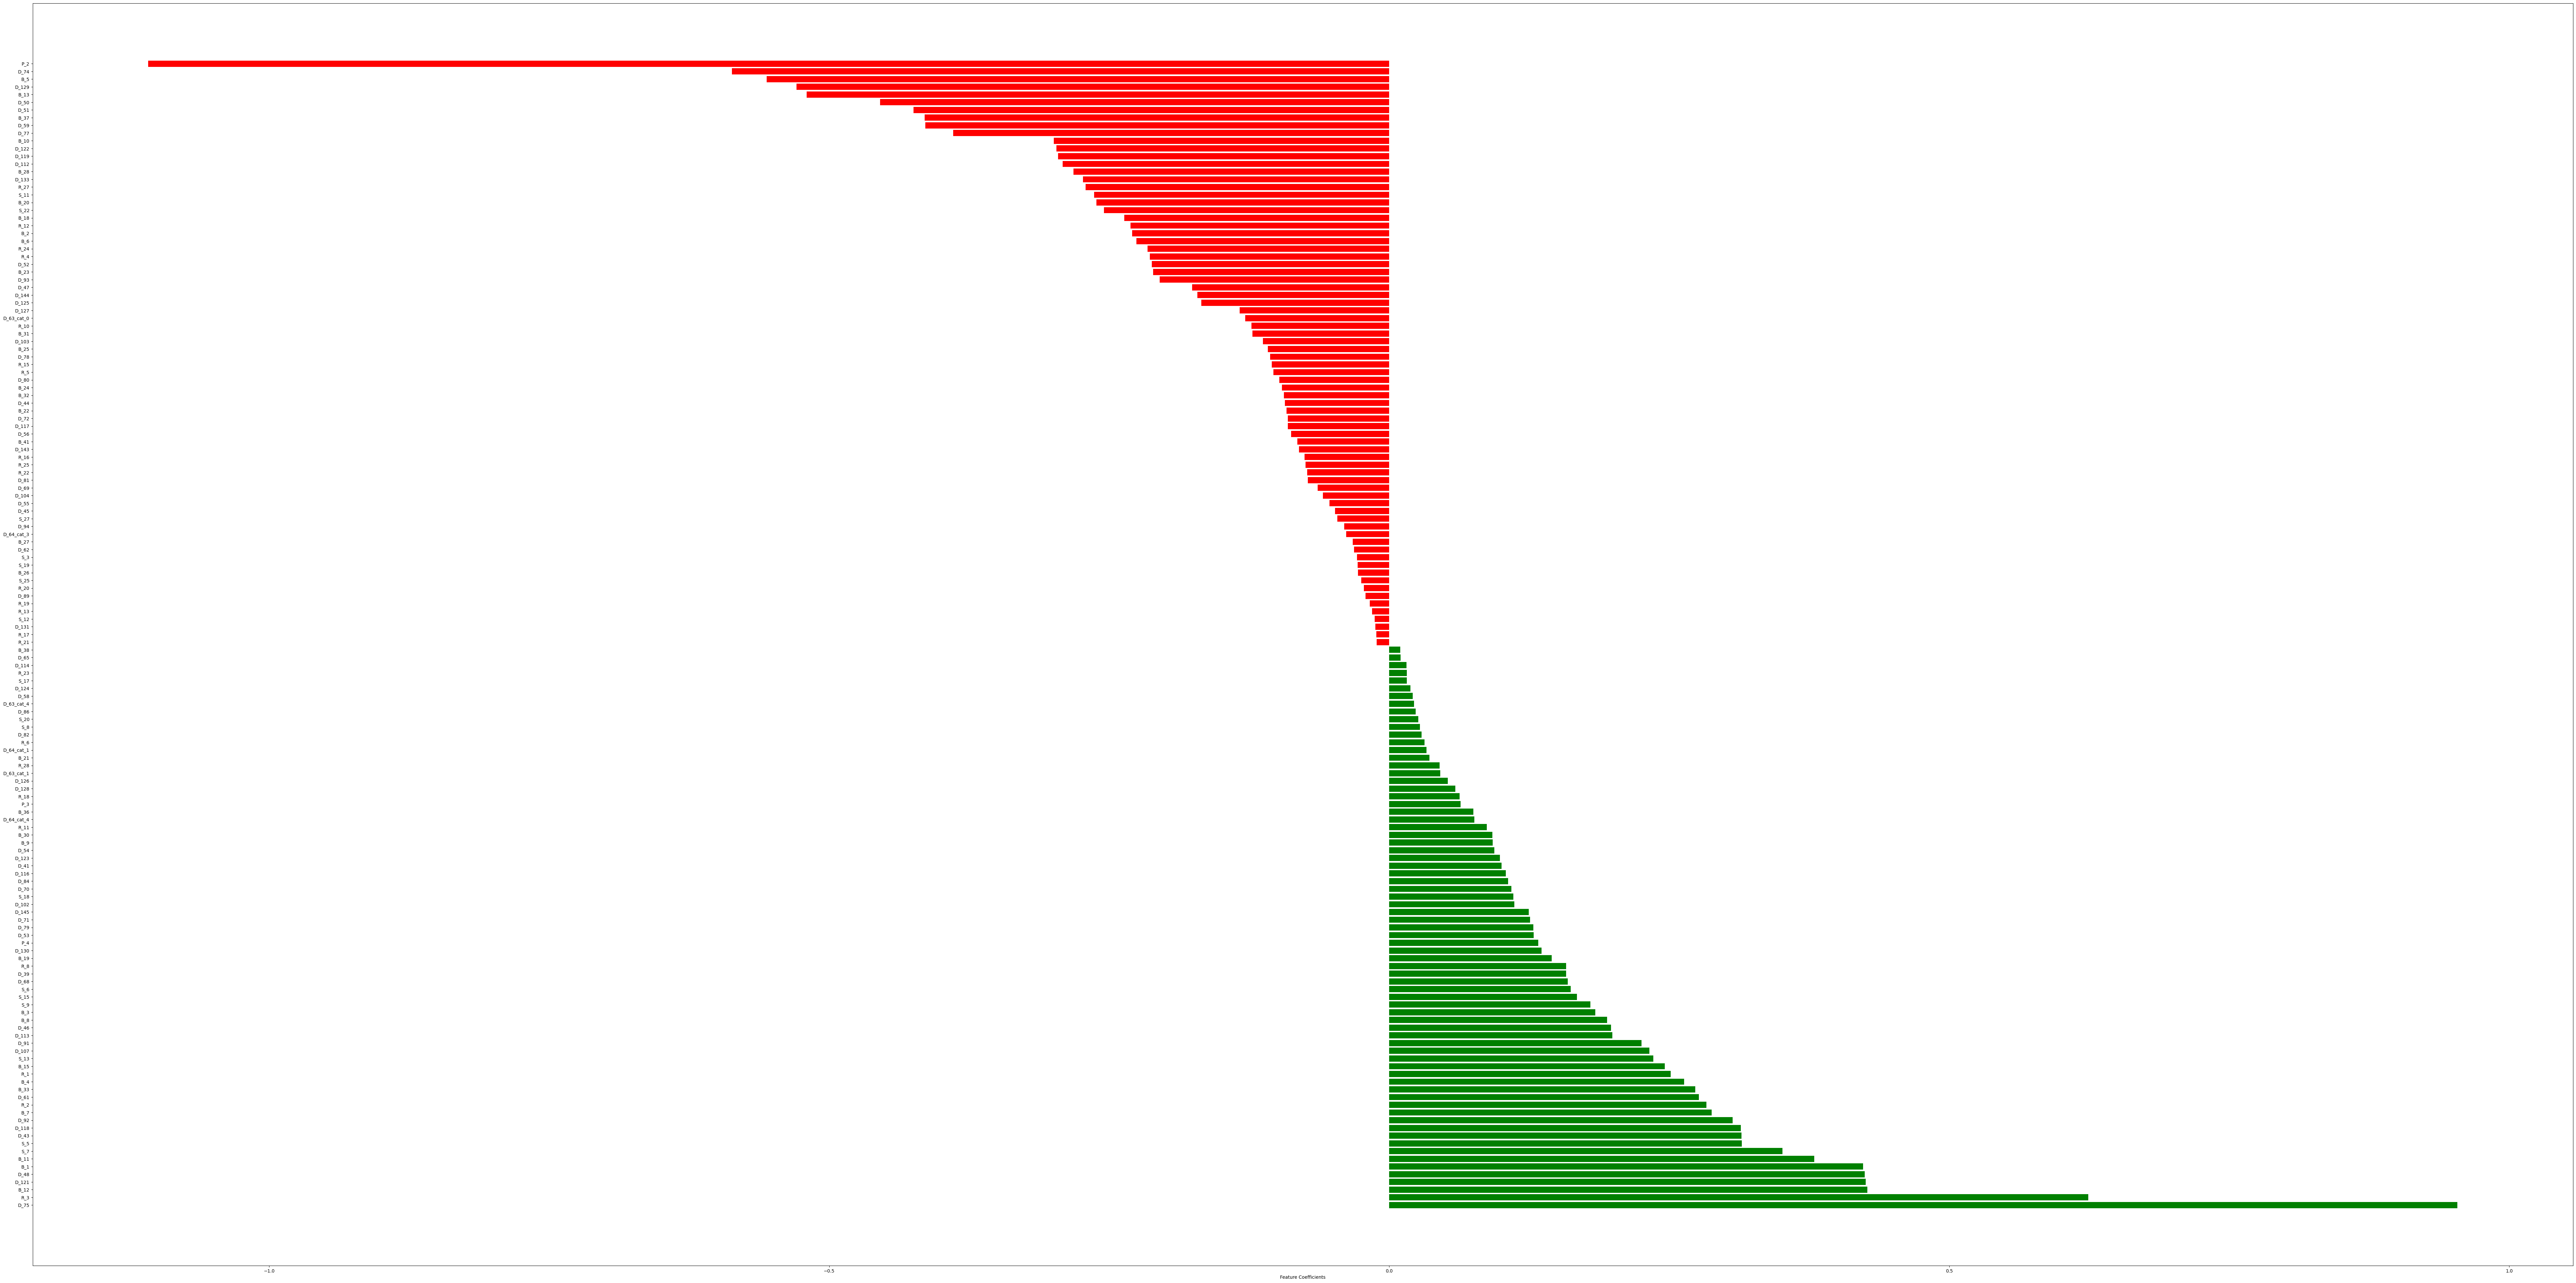

In [89]:
visualize_coefs(coef_dict)

## Conclusion
The XGBoost model is reasonaly well for performance. One of the biggiest problem of this model is however it doesnot inclued all the neccessary dataset. Further improvement is to extend the study for full dataset with bigger computer resource